# LABORATORIUM 4 - KLASYFIKATOR SVM

### 3.1 Implementacja liniowego SVMa

In [104]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#### Funkcje do generowania zbiorów:

In [105]:
def generate_data(n_samples, n_features, random_state):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=random_state
    )
    y = 2 * y - 1
    return X, y

def generate_moons(n_samples, random_state):
    X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
    y_moons = 2 * y_moons - 1
    return X_moons, y_moons

#### Funkcje do liczenia metryk i statystyk:

In [113]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

def evaluate_classifier(y_test, y_pred, X, y, model, classifier_name, dataset_name, labels=[0,1]):
    # Oblicz metryki
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Wyświetl metryki
    print(f"{classifier_name} na {dataset_name}:")
    print(f"Skuteczność: {accuracy*100:.4f}%")
    print(f"Czułość (Recall): {sensitivity*100:.4f}%")
    print(f"Swoistość: {specificity*100:.4f}%")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Przygotuj wykresy
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Macierz pomyłek
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=axes[0], cmap='Greens', colorbar=False)
    axes[0].set_title("Macierz pomyłek")

    # Krzywa ROC
    axes[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--')  # linia referencyjna
    axes[1].set_xlabel('1 - Swoistość (False Positive Rate)')
    axes[1].set_ylabel('Czułość (True Positive Rate)')
    axes[1].set_title('Krzywa ROC')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Granica decyzyjna z czerwonym i niebieskim tłem
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    custom_cmap = ListedColormap(['red', 'blue'])
    axes[2].contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)
    scatter = axes[2].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=custom_cmap, s=50)
    axes[2].set_title("Granica decyzyjna")
    axes[2].set_xlabel("Feature 1")
    axes[2].set_ylabel("Feature 2")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


#### Właśna implementacja SVM:

In [123]:
from scipy.optimize import minimize

class SVM_Linear: 
    def __init__(self, learning_rate=0.001):
        self.lr = learning_rate
        self.w = None
        self.b = None
        self.lambdas = None

    def dual_svm(self, lambdas, X, y):
        K = X @ X.T
        L = np.outer(lambdas, lambdas)
        Y = np.outer(y, y)
        return -np.sum(lambdas) + 0.5 * np.sum(L * Y * K)
        
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        ## ograniczenia:
        bounds = [(0, None) for _ in range(n_samples)] ## lambda >= 0
        constraints = {'type': 'eq', 'fun': lambda l: np.dot(l, y)} ## suma lambd @ y musi być równa 0

        init_lambdas = np.random.rand(n_samples)

        result = minimize(
            fun=self.dual_svm,
            x0=init_lambdas,
            args=(X, y),
            bounds=bounds,
            constraints=constraints
        )
        self.lambdas = result.x

        self.w = np.sum((self.lambdas * y)[:, None] * X, axis=0)

        support_vectors = (self.lambdas > 1e-5) ## tylko dla punktów nośnych
        b_vals = y[support_vectors] - np.dot(X[support_vectors], self.w)
        self.b = np.mean(b_vals)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)



#### Porównanie własnej implementacji z **SVC** z biblioteki *sklearn*:

#### Własna implementacja na zbiorze *generate data* i *make moons*:

Czas wykonania: 3.188584566116333s.
Własna implementacja na Generate data:
Skuteczność: 77.5000%
Czułość (Recall): 62.5000%
Swoistość: 100.0000%
ROC AUC: 0.8125


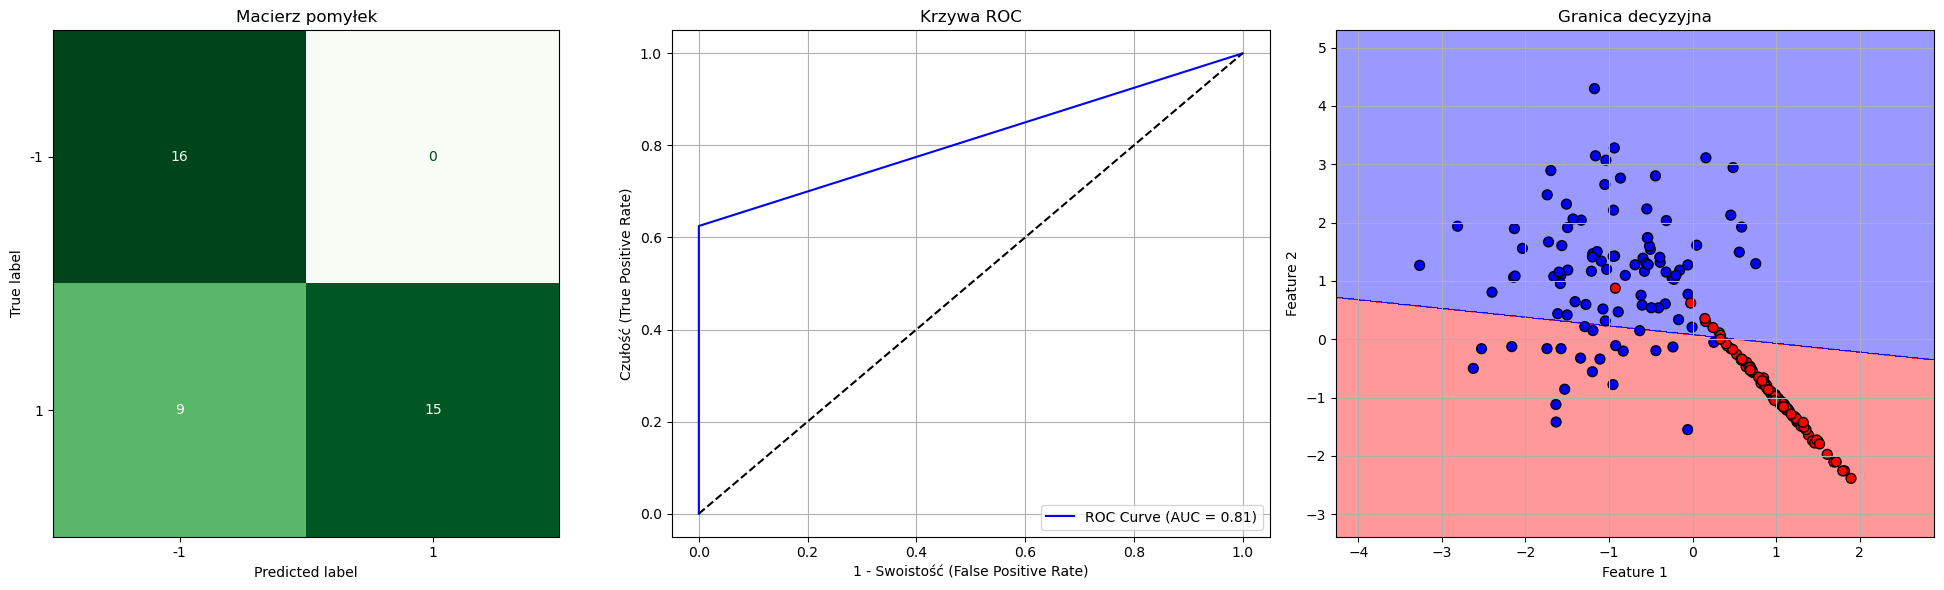

In [124]:
X, y = generate_data(200, 2, 259195)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(1):
    model = SVM_Linear()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_test, y_pred, X, y, model, "Własna implementacja", "Generate data", [-1, 1])


Czas wykonania: 3.213567018508911s.
Własna implementacja na Make moons:
Skuteczność: 70.0000%
Czułość (Recall): 72.2222%
Swoistość: 68.1818%
ROC AUC: 0.7020


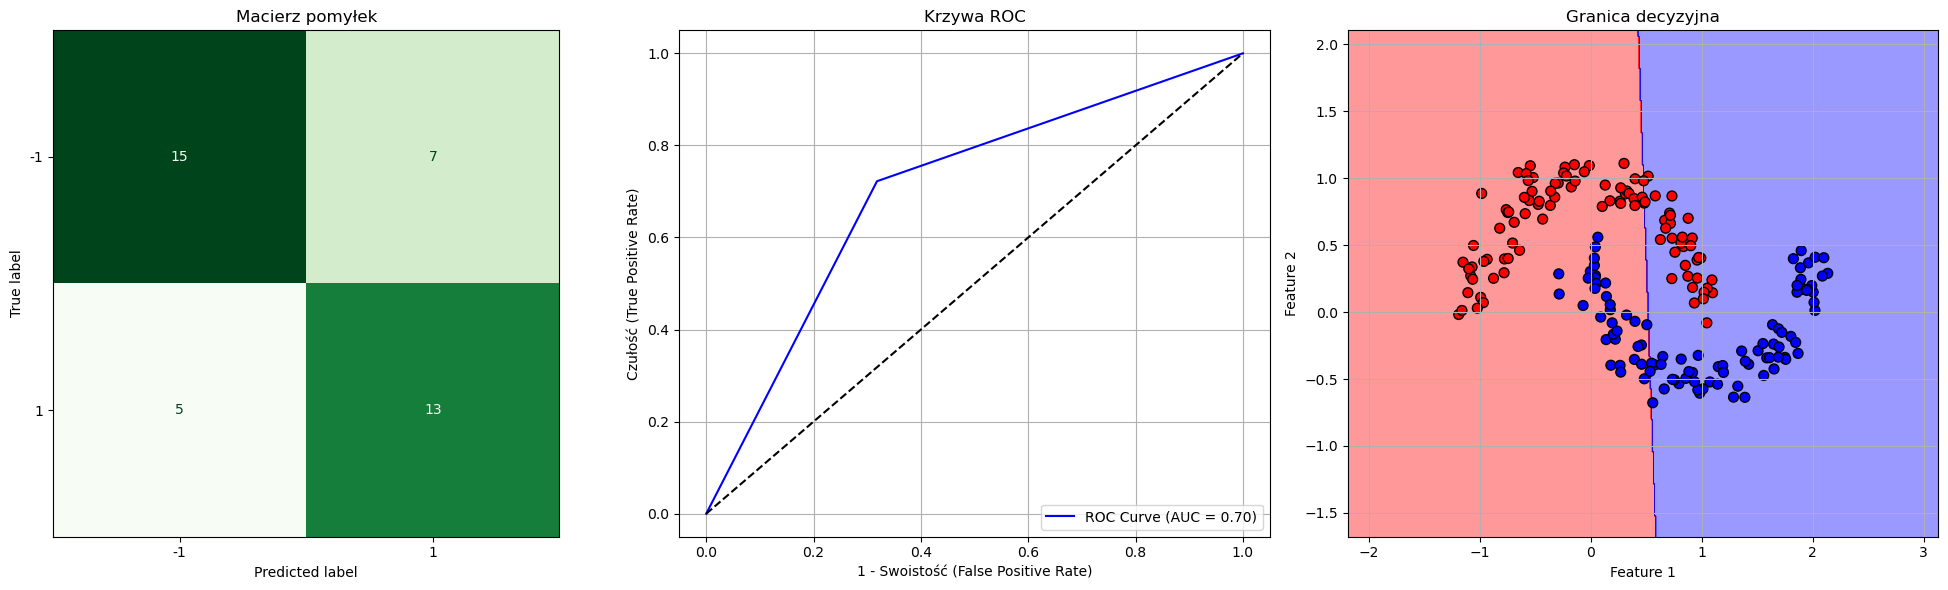

In [125]:
X, y = generate_moons(200, 259195)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=259195)

start = time.time()
for _ in range(1):
    model = SVM_Linear()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
end = time.time()
print(f"Czas wykonania: {end - start}s.")
evaluate_classifier(y_test, y_pred, X, y, model, "Własna implementacja", "Make moons", [-1, 1])


### 3.2 Implementacja SVMa wykorzystującego funkcję jądra 